# Logistic Regression with Differential Privacy

We start by importing the required libraries and modules and collecting the data that we need from the [Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult).

In [1]:
import diffprivlib.models as dp
import numpy as np
from sklearn.linear_model import LogisticRegression

In [2]:
X_train = np.genfromtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=(0, 4, 10, 11, 12), delimiter=",")

y_train = np.genfromtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=14, dtype=str, delimiter=",")

In [3]:
np.unique(y_train)

array([' <=50K', ' >50K'], dtype='<U6')

Let's also collect the test data from Adult to test our models once they're trained.

In [4]:
X_test = np.genfromtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=(0, 4, 10, 11, 12), delimiter=",", skip_header=1)

y_test = np.genfromtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=14, dtype=str, delimiter=",", skip_header=1)

# Must trim trailing period "." from label
y_test = np.array([a[:-1] for a in y_test])

In [5]:
np.unique(y_test)

array([' <=50K', ' >50K'], dtype='<U6')

## Logistic Regression with no privacy

To begin, let's first train a regular (non-private) logistic regression classifier, and test its accuracy.

In [6]:
clf = LogisticRegression(solver="lbfgs", max_iter=150)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=150)

In [7]:
baseline = clf.score(X_test, y_test)
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

Non-private test accuracy: 81.28%


## Differentially private logistic regression

Using the `diffprivlib.models.LogisticRegression` module of diffprivlib, we can train a logistic regression classifier while satisfying differential privacy.

If we don't specify any parameters, the model defaults to `epsilon = 1` and `data_norm = None`. If the norm of the data is not specified at initialisation (as in this case), the norm will be calculated on the data when `.fit()` is first called and a warning will be thrown as it causes a privacy leak. To ensure no additional privacy leakage, we should specify the data norm explicitly as an argument, and choose the bounds indepedently of the data (i.e. using domain knowledge).

Additionally, the high `data_norm` that is read from the data in this instance gives poor results, with accuracy only slightly better than random. This is as a result of the large amount of noise requires to protect data spread over a large domain. By clipping the data to a smaller domain, accuracy improves markedly, as demonstrated below.

In [8]:
dp_clf = dp.LogisticRegression(random_state=0)
dp_clf.fit(X_train, y_train)

venv3.12/lib/python3.12/site-packages/diffprivlib/models/logistic_regression.py:231: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


LogisticRegression(accountant=BudgetAccountant(spent_budget=[(1.0, 0)]),
                   data_norm=np.float64(99999.04562544584), random_state=0)

In [9]:
print("Differentially private test accuracy (epsilon=%.2f): %.2f%%" % 
     (dp_clf.epsilon, dp_clf.score(X_test, y_test) * 100))

Differentially private test accuracy (epsilon=1.00): 79.50%


By setting `epsilon = float("inf")`, we can produce the same result as the non-private logistic regression classifer.

In [10]:
dp_clf = dp.LogisticRegression(epsilon=float("inf"), data_norm=1e5, max_iter=150)
dp_clf.fit(X_train, y_train)

LogisticRegression(accountant=BudgetAccountant(spent_budget=[(1.0, 0), (inf, 0)]),
                   data_norm=100000.0, epsilon=inf, max_iter=150)

In [11]:
print("Agreement between non-private and differentially private (epsilon=inf) classifiers: %.2f%%" % 
     (dp_clf.score(X_test, clf.predict(X_test)) * 100))

Agreement between non-private and differentially private (epsilon=inf) classifiers: 100.00%


## Tradeoff of accuracy and privacy

We can also visualise the tradeoff between accuracy and `epsilon` using `matplotlib`.

In [12]:
from diffprivlib.utils import check_random_state

accuracy = []
epsilons = np.logspace(-3, 1, 500)
random_state = check_random_state(42)
n = X_train.shape[0]  # Increased regularisation improves performance in this example

for eps in epsilons:
    dp_clf = dp.LogisticRegression(epsilon=eps, data_norm=2, random_state=random_state, C=1/n)
    dp_clf.fit(X_train, y_train)
    accuracy.append(dp_clf.score(X_test, y_test))

Let's plot the results using `matplotlib`. Because of the norm-clipping applied to the dataset before training (`data_norm=2`), the accuracy plateaus without reaching the non-private baseline.

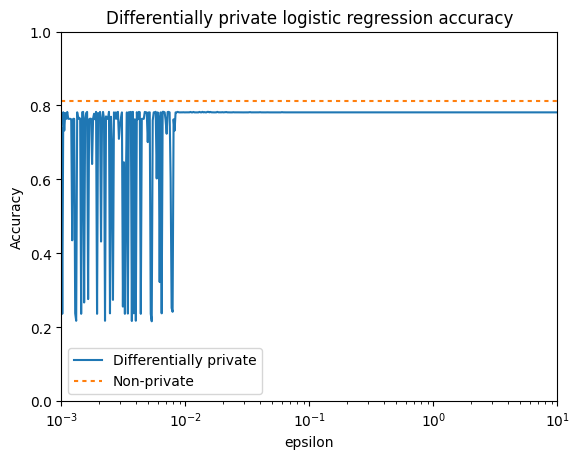

In [13]:
import matplotlib.pyplot as plt

plt.semilogx(epsilons, accuracy, label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Differentially private logistic regression accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=3)
plt.show()